In [325]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import activations
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from math import *

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 1. Generate Data

(6.09, -837.4)
109


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


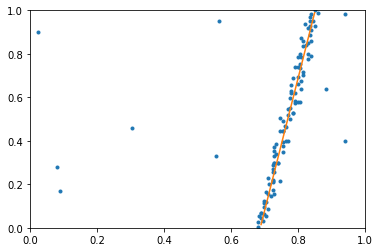

In [210]:
sigma_noise = [2, 2]
image_size = (200, 200)

def generate_line(image):
    a = int(random.uniform(-10, 10) * 100) / 100
    p = (np.random.randint(image[0]), np.random.randint(image[1]))
    b = p[1] - a*p[0]
    return (a, b)

def compute_line_from_points(p1, p2, image):
    x1, y1 = int(image[0]*p1[0]), int(image[1]*p1[1])
    x2, y2 = int(image[0]*p2[0]), int(image[1]*p2[1])
    if (x2-x1) != 0:
        a = int((y2-y1)/(x2-x1) * 100) / 100
    else:
        a = 100
    b = y1 - a*x1
    return (a, b)
    

def generate_data(line, image, sigma, n_inliers, n_outliers):
    a, b = line
    L_X = []
    L_Y = []
    Points = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            p = np.array([x, y])
            Points.append(p)
    covariance = np.diag(np.array(sigma) ** 2)
    n_i = max(1, n_inliers // len(Points))
    for point in Points:
        sample = np.random.multivariate_normal(point, covariance, n_i)
        sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
        sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
        L_X.extend(sample_X)
        L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

def plot_data(D, ax, c=None):
    L_x, L_y = D
    ax.plot(L_x, L_y, '.', c=c)

def plot_line(line, image, ax, c=None):
    a, b = line
    X = []
    Y = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            X.append(x/image[0])
            Y.append(y/image[1])
    ax.plot(X, Y, c=c)
    
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line = generate_line(image_size)
print(line)
D = generate_data(line, image_size, sigma_noise, 100, 10)
plot_data(D, ax)
plot_line(line, image_size, ax)
fig.show()
#print(D)
print(len(D[0]))

### Loss between 2 lines

(9.16, -733.5600000000001)
(-4.13, 384.78999999999996)
34941
5059
True
area final =  0.873525


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


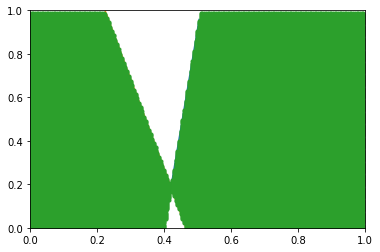

In [186]:
def point_y_in_image(l, x, image_y):
    a, b = l
    y = int(a*x+b)
    y = min(max(y, 0), image_y-1)
    return y

def intersect(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    if a1 == a2:
        return False
    else:
        x = (b2 - b1)/(a1-a2)
        y = a1*x+b1
        if x >= 0 and x < image[0] and y >= 0 and y < image[1]:
            return True
        else:
            return False

def change_sign(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    d1 = b1 - b2
    x = image[0]
    d2 = (a1*x+b1)-(a2*x+b2)
    if d1*d2 < 0:
        return True
    else:
        return False

def loss_weights(l1, l2, image):
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
    area2 = image[0]*image[1] - area1
    
    inter = intersect(l1, l2, image)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    #print("area final = ", area)
    area = 1 - (area/(image[0]*image[1]))
    return area

def plot_loss(l1, l2, image, ax):
    plot_line(l1, image_size, ax)
    plot_line(l2, image_size, ax)
    area_X = []
    area_Y = []
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
        for k in range(min(y1, y2), max(y1, y2)):
            area_X.append(x/image[0])
            area_Y.append(k/image[1])
    ax.plot(area_X, area_Y, '.')
    print(area1)
    area2 = image[0]*image[1] - area1
    print(area2)
    
    inter = intersect(l1, l2, image)
    print(inter)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        print(sign)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1

    area = 1 - (area/(image[0]*image[1])) 
    print("area final = ", area)

    fig.show()

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line1 = generate_line(image_size)
print(line1)

line2 = generate_line(image_size)
print(line2)
plot_loss(line1, line2, image_size, ax)

### Neural network model

In [187]:
class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(1024)
        self.bn_4 = nn.BatchNorm1d(512)
        self.bn_5 = nn.BatchNorm1d(256)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]

        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x

class BasePointNet(nn.Module):

    def __init__(self, point_dimension, return_local_features=False):
        super(BasePointNet, self).__init__()
        self.return_local_features = return_local_features
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)

        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(1024)

    def forward(self, x):
        num_points = x.shape[1]

        input_transform = self.input_transform(x)

        x = torch.bmm(x, input_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x)

        x = torch.bmm(x, feature_transform)
        local_point_features = x

        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        if self.return_local_features:
            x = x.view(-1, 1024, 1).repeat(1, 1, num_points)
            return torch.cat([x.transpose(2, 1), local_point_features], 2), feature_transform
        else:
            return x, feature_transform

class FeaturesPointNet(nn.Module):

    def __init__(self, dropout, point_dimension):
        super(FeaturesPointNet, self).__init__()
        self.base_pointnet = BasePointNet(return_local_features=False, point_dimension=point_dimension)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        #self.fc_3 = nn.Linear(256, num_classes)

        self.bn_1 = nn.BatchNorm1d(512)
        self.bn_2 = nn.BatchNorm1d(256)

        self.dropout_1 = nn.Dropout(dropout)

    def forward(self, x):
        x, feature_transform = self.base_pointnet(x)

        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout_1(x)

        #return F.log_softmax(self.fc_3(x), dim=1), feature_transform
        return x, feature_transform


class Weights(nn.Module):

    
    def __init__(self, dropout=0.3, point_dimension=2):
        super(Weights, self).__init__()
        self.point1 = FeaturesPointNet(dropout, point_dimension)
        self.point2 = FeaturesPointNet(dropout, point_dimension)

        self.fc_1 = nn.Linear(518, 1)
        
        
    def forward(self, x):
        #print(x.shape)
        n = (x.shape[1] - 3)//2
        x1 = x[:, :n]
        x2 = x[:, n:2*n]
        v = x[:, 2*n]
        p1 = x[:, 2*n+1]
        p2 = x[:, 2*n+2]
        #print("x1.shape= ", x1.shape)
        #print("x2.shape= ", x2.shape)
        #print("v.shape = ", v.shape)
        
        assert 2*n+2==x.shape[1]-1
        
        x1, feature_transform1 = self.point1(x1)
        x2, feature_transform2 = self.point2(x2)
        #print("feature1.shape = ", x1.shape)
        #print("feature2.shape = ", x2.shape)
        #print(feature_transform1.shape)
        
        x_tot = torch.cat((x1, x2), dim=1)
        #print("x_tot.shape = ", x_tot.shape)

        x = torch.cat((x_tot, v), dim=1)
        x = torch.cat((x, p1), dim=1)
        x = torch.cat((x, p2), dim=1)

        #print("x.shape = ", x.shape)
        #print("x = ", x)
        
        x = F.relu(self.fc_1(x))

        return x #, feature_transform


In [188]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return sqrt((x1-x2)**2+(y1-y2)**2)

def reorder(L, M):
    p = L[-1]
    d = M[-1]
    k = len(L) - 2
    while k >= 0 and M[k] > d:
        L[k+1] = L[k]
        M[k+1] = M[k]
        k -= 1
    L[k+1] = p
    M[k+1] = d

def nearest_neighbors(data, i, k):
    p = (data[0][i], data[1][i])
    L = []
    M = []
    n = len(data[0])
    for j in range(n):
        (x, y) = (data[0][j], data[1][j])
        d = dist((x, y), p)
        if len(L) < k:
            L.append((x, y))
            M.append(d)
            reorder(L, M)
        else:
            d2 = M[-1]
            if d < d2:
                L[-1] = (x, y)
                M[-1] = d
                reorder(L, M)
    return L

In [189]:
def center_points(points, p):
    (x, y) = p
    L = []
    for point in points:
        (xp, yp) = point
        L.append([xp-x, yp-y])
    return L

def compute_features(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    k = 10
    x1 = center_points(nearest_neighbors(data, i1, k), p1)
    x2 = center_points(nearest_neighbors(data, i2, k), p2)
    feature = x1+x2
    feature.append(vec)
    feature.append([p1[0], p1[1]])
    feature.append([p2[0], p2[1]])
    return feature
    

def generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers):
    Lines = []
    Datas = []
    X = []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                feature=compute_features(data, i1, i2)
                X.append(feature)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2, image)
                area = loss_weights(line_ref, line, image)
                Y.append(area)
    #print(type(X))
    X_tensor = torch.Tensor(X)
    Y_tensor = torch.Tensor(Y)
    #print(type(X_tensor))
    #print(X_tensor.shape)
    return (X_tensor, Y_tensor)

def split_training(xy, prop=0.1):
    (X, Y) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    x_train = X[k:]
    y_train = Y[k:]
    return ((x_test, y_test), (x_train, y_train))

In [326]:
model = Weights().to(DEVICE)

sigma_noise = [2, 2]
image_size = (200, 200)


In [ ]:
def train_model(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers=100, nbr_outliers=10):
    ((x_test, y_test), (x_train, y_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers))
    x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.00001)
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=2*batch_size)
    for k in range(epochs):
        for xb, yb in train_dl:
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(x_train)
            loss = loss_fn(y_predict, y_train)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = sum(loss_fn(model(xb), yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss.item(), " ; loss_eval = ", loss_eval.item() / len(valid_dl))
        
        if k == nbr_step - 1:
            last_weight = model(x_test)
            print(last_weights)
            
    return model

model_trained = train_model(model, image_size, sigma_noise, nbr=50, nbr_per_line=196, epochs=50, batch_size=200, nbr_inliers=150, nbr_outliers=20)



data generated


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


tensor([0.]) tensor([0.])
(0.715, 0.74)
[0.99265] [0.5259750000000001]
(0.715, 0.74)
tensor([0.]) tensor([0.])
(0.75, 0.065)
[0.9286] [0.503675]
(0.75, 0.065)
tensor([0.]) tensor([0.])
(0.615, 0.105)
[0.99745] [0.5548500000000001]
(0.615, 0.105)
tensor([0.]) tensor([0.])
(0.65, 0.33)
[0.99895] [0.5072749999999999]
(0.65, 0.33)
tensor([0.]) tensor([0.])
(0.195, 0.145)
[0.786] [0.45694999999999997]
(0.195, 0.145)


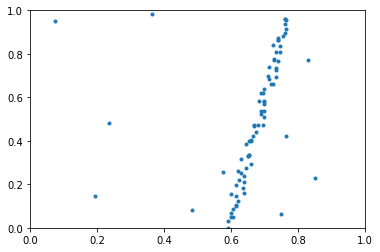

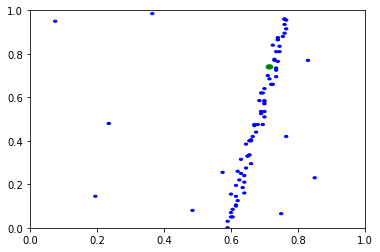

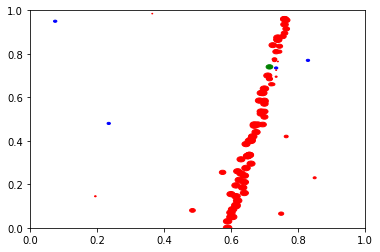

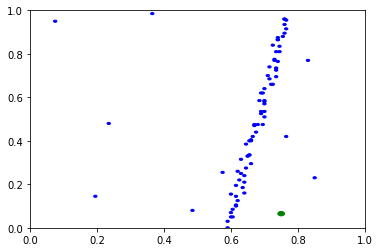

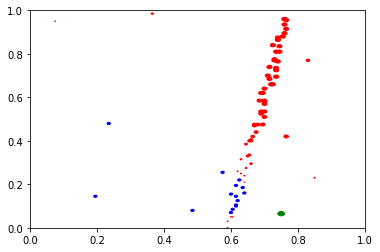

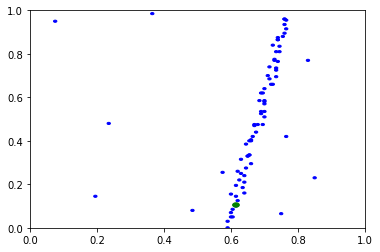

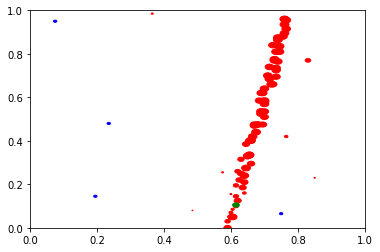

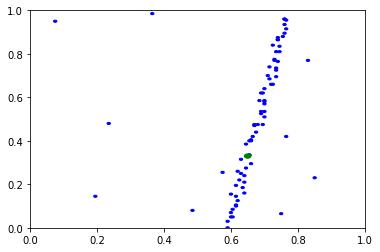

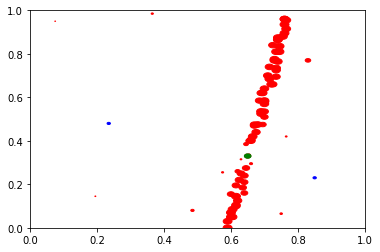

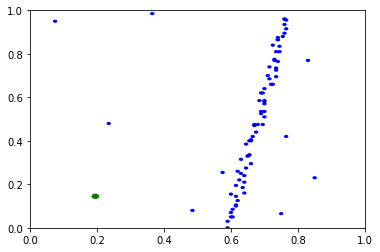

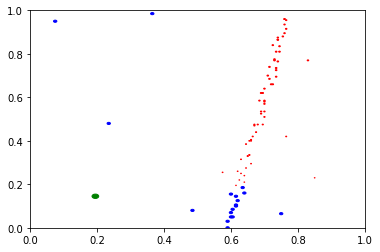

In [191]:
def plot_weights(weights, coord, p1, image, ref=False):
    print(max(weights), min(weights))
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    n = len(weights)

    for i in range(n):
        (x, y) = coord[i]
        w = weights[i]
        if isinstance(w, list):
            w = w[0]
        r = (exp(10*w)/exp(7))
        if ref:
            r = exp(8*w)/exp(7)/image[0]
        circle = plt.Circle((x, y), r, color='r')
        if r <= 10**(-3):
            circle = plt.Circle((x, y), 1./image[0], color='b')

        ax.add_artist(circle)
    print(p1)
    circle_1 = plt.Circle(p1, 2./image[0], color='g')
    ax.add_artist(circle_1)
    fig.show()
    

def test_nn(model, image, sigma, nbr_inliers=100, nbr_outliers=10):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(5):
        i1 = np.random.randint(n)
        X = []
        coord = []
        weights_ref = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature=compute_features(data, i1, i2)
                X.append(feature)
                X_tensor = torch.Tensor(X)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                area = loss_weights(line_ref, line, image)
                weights_ref.append([area])
                
                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():
            weights = model(X_tensor)
        
        plot_weights(weights, coord, p1, image)
        plot_weights(weights_ref, coord, p1, image, ref=True)

test_nn(model, image_size, sigma_noise)

### Compute weights from model

In [290]:
def compute_weights_ref(line_ref, image, data, i1):
    coord = []
    weights_ref = []
    p1 = (data[0][i1], data[1][i1])
    n = len(data[0])
    for i2 in range(n):
        if i2==i1:
            weights_ref.append(0)
        else:
            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2, image)
            area = loss_weights(line_ref, line, image)
            weights_ref.append(area)

        coord.append((data[0][i2], data[1][i2]))
    return weights_ref


In [291]:
def compute_weights(model, data, i1):
    weights = []
    n = len(data[0])
    
    print(data)
    p1 = data[0][i1], data[1][i1]
    for i2 in range(n):
        if i2==i1:
            weights.append(0)
        else:
            features = compute_features(data, i1, i2)
            p2 = data[0][i2], data[1][i2]
            w = model.predict(features)
            weights.append(w)
    return weights

def sample_from_weights(data, weights, sample, sigma=5):
    n = len(data[0])
    m = 1
    if len(sample) == 0:
        x1 = np.random.randint(n)
        while weights[x1] == 0:
            x1 = np.random.randint(n)
        for k in range(1000):
            x2 = int(np.random.normal(loc=x1, scale=sigma))
            while x2 < 0 or x2 >= n:
                x2 = int(np.random.normal(loc=x1, scale=sigma))
            alpha = weights[x2]/weights[x1]
            u = random.uniform(0, 1)
            if u <= alpha:
                x1 = x2
    else:
        x1 = sample[-1]
    
    for k in range(m):
        x2 = int(np.random.normal(loc=x1, scale=sigma))
        while x2 < 0 or x2 >= n:
            x2 = int(np.random.normal(loc=x1, scale=sigma))
        alpha = weights[x2]/weights[x1]
        u = random.uniform(0, 1)
        if u <= alpha:
            x1 = x2
        sample.append(x1)


### Ransac

In [318]:
def get_inliers(data, line, threshold, image):
    a, b = line
    X, Y = data
    Inliers = [[], []]
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        (xb, yb) = x*image[0], y*image[1]
        if abs((a*xb+b) - yb) < threshold:
            Inliers[0].append(x)
            Inliers[1].append(y)
    return Inliers

def get_model(model, data, image, sample, line_ref=None):
    n = len(data[0])
    i1 = np.random.randint(n)
    #weights = compute_weights(model, data, i1)
    weights = compute_weights_ref(line_ref, image, data, i1)
    sample_from_weights(data, weights, sample)
    i2 = sample[-1]
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line #, weights, i1


def update_stopping_criterion(k, inliers, proba):
    if k >= 150:
        return True
    return False


def ransac(data, threshold, image, proba, line_ref=None, model=None, compare=False):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        sample = []
        line = get_model(model, data, image, sample, line_ref)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

In [262]:
image = image_size
sigma = sigma_noise
n_inliers=150
n_outliers=50
proba = 0.1

line = generate_line(image)
data = generate_data(line, image, sigma, n_inliers, n_outliers)
    
threshold = 12
    
k = 0
inliers_max = [[], []]
line_max = None
end = False
line_ref = line

In [ ]:
sample = []
line2, weights, i1 = get_model(model, data, image, sample, line_ref)
p1 = (data[0][i1], data[1][i1])
inliers = get_inliers(data, line2, threshold, image)
if len(inliers[0]) > len(inliers_max[0]):
    inliers_max = inliers
    line_max = line2
k += 1
end = update_stopping_criterion(k, inliers, proba)

print("------------------------------------")
print("nbr inliers = ", len(inliers[0]))
print("line = ", line2)
print("max inliers so far = ", len(inliers_max[0]))
print("end = ", end)
print("sample = ", sample)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plot_data(data, ax, c='b')
ax.plot([p1[0]], [p1[1]], c='g')
plot_data(inliers, ax, c='r')
plot_line(line2, image, ax, c='g')
fig.show()

coord = [(data[0][i], data[1][i]) for i in range(len(data[0]))]
plot_weights(weights, coord, p1, image, ref=True)


------------------------------------
nbr inliers =  14
line =  (0.29, 15.75)
max inliers so far =  14
------------------------------------
nbr inliers =  2
line =  (18.6, -550.6)
max inliers so far =  14
------------------------------------
nbr inliers =  93
line =  (0.79, 8.399999999999991)
max inliers so far =  93
------------------------------------
nbr inliers =  3
line =  (15.33, -141.26)
max inliers so far =  93
------------------------------------
nbr inliers =  75
line =  (0.93, -3.3000000000000007)
max inliers so far =  93
------------------------------------
nbr inliers =  102
line =  (0.83, 6.140000000000001)
max inliers so far =  102
------------------------------------
nbr inliers =  143
line =  (0.84, 3.4399999999999977)
max inliers so far =  143
------------------------------------
nbr inliers =  126
line =  (0.82, 3.1000000000000085)
max inliers so far =  143
------------------------------------
nbr inliers =  105
line =  (0.86, -2.260000000000005)
max inliers so far = 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(0.84, 3.4399999999999977)

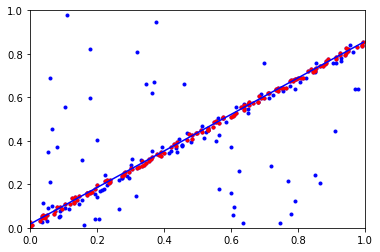

In [286]:
def test_weights_ref(image, sigma, n_inliers=150, n_outliers=50):
    line = generate_line(image)
    data = generate_data(line, image, sigma, n_inliers, n_outliers)
    
    threshold = 3
    proba = 0.1
    
    line_predict, inliers = ransac(data, threshold, image, proba, line_ref=line)
    
    
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax, c='b')
    plot_data(inliers, ax, c='r')
    #plot_line(line, image, ax, c='g')
    plot_line(line_predict, image, ax, c='b')
    fig.show()
    
    print("prediction = ", line_predict)
    print("ref = ", line)
    
    return line_predict

test_weights_ref(image_size, sigma_noise)

### Compare with and without weights

In [319]:
def get_model_uniform(data, image):
    n = len(data[0])
    i1 = np.random.randint(n)
    i2 = np.random.randint(n)
    while i1 == i2:
        i2 = np.random.randint(n)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def ransac_uniform(data, threshold, image, proba):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model_uniform(data, image)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    return line_max, inliers_max, nbr_inliers

In [322]:
def plot_lines(data, line1, line2, image):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax, c='b')
    plot_line(line1, image, ax, c='g')
    #plot_line(line2, image, ax, c='r')
    fig.show()


def compare_uniform(image, sigma, average=5, n_inliers=150, n_outliers=50):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    nbr_inliers_sample = [0]*it
    nbr_inliers_uniform = [0]*it
    
    for k in range(average):
        line_predict1, inliers1, nbr_inliers1 = ransac(Datas[k], threshold, image, proba, line_ref=Lines[k], compare=True)
        line_predict2, inliers2, nbr_inliers2 = ransac_uniform(Datas[k], threshold, image, proba)
        plot_lines(Datas[k], line_predict1, line_predict2, image)
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_uniform[j] += nbr_inliers2[j]
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_uniform[j] /= average
        
    fig, ax = plt.subplots()
    ax.plot(nbr_inliers_sample, c='g')
    ax.plot(nbr_inliers_uniform, c='r')
    fig.show()
    
    print("done")



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


done


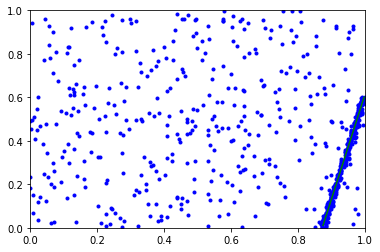

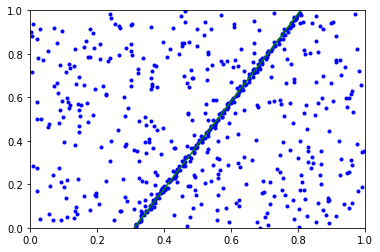

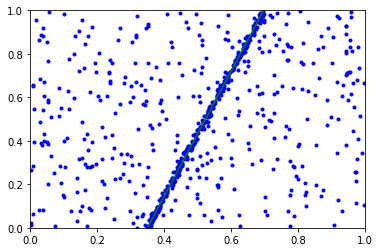

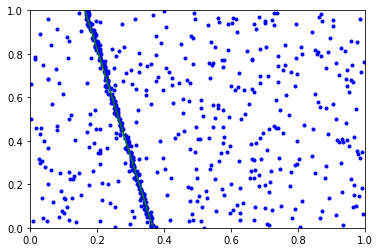

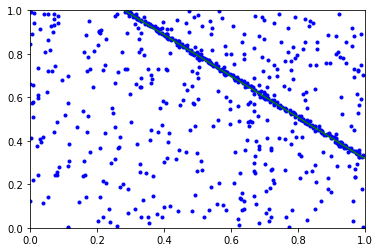

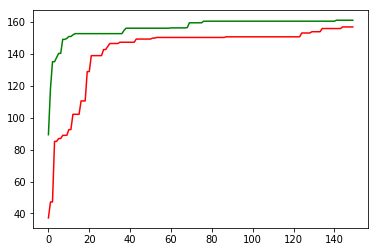

In [323]:
image_size = [400, 400]
n_inliers = 300
n_outliers = 400

compare_uniform(image_size, sigma_noise, n_inliers=n_inliers, n_outliers=n_outliers)